In [1]:
# from google.colab import drive
# drive.mount('/gdrive')

# import sys
# sys.path.append('/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/')

In [2]:
from __future__ import print_function
import os
import argparse
from glob import glob
import cv2 as cv
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from model import LLE
from utils import *

from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

C:\Users\HP\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# # Take command line arguments and save as variable

# tf.reset_default_graph()
# parser = argparse.ArgumentParser(description='')
# parser.add_argument('--use_gpu', dest='use_gpu', type=int, help='1 for GPU and 0 for CPU')
# parser.add_argument('--phase', dest='phase', default='train', help='train or test')
# parser.add_argument('--epoch', dest='epoch', type=int, default=100, help='number of epoches')
# parser.add_argument('--batch_size', dest='batch_size', type=int, default=5, help='number of samples in one batch')
# parser.add_argument('--patch_size', dest='patch_size', type=int, default=256, help='patch size')
# parser.add_argument('--checkpoint_dir', dest='ckpt_dir', default='./checkpoint', help='directory for checkpoints')
# parser.add_argument('--save_dir', dest='save_dir', default='./Enhanced_result', help='directory for testing outputs')
# parser.add_argument('--test_dir', dest='test_dir', default='./data/test', help='directory for testing inputs')
# args = parser.parse_args()

In [4]:
def LiCENt_train(lle_model, checkpoint_dir, train_data_path_low, train_data_path_high, image_format, batch_size, patch_size, epochs):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    train_low_data = []
    train_high_data = []
    train_low_data_names = glob(train_data_path_low+'/*.'+image_format)
    train_low_data_names.sort()
    train_high_data_names = glob(train_data_path_high+'/*.'+image_format)
    train_high_data_names.sort()
    assert len(train_low_data_names) == len(train_high_data_names)
    print('[*] Number of training data: %d' % len(train_low_data_names))
    print('prepare training data')
    for idx in range(len(train_low_data_names)):
        if (idx+1)%100 == 0:
            print('%d / %d' % (idx+1, len(train_low_data_names)))
        low_im = load_img(train_low_data_names[idx], flag=0)
        low_im = low_im[:,:,np.newaxis]
        train_low_data.append(low_im)
        high_im = load_img(train_high_data_names[idx], flag=0)
        high_im = high_im[:,:,np.newaxis]
        train_high_data.append(high_im)
    print('Training data ready, Total training data: %d' % len(train_low_data))
    training_loss = lle_model.train(train_low_data, train_high_data, batch_size=batch_size, patch_size=patch_size, epoch=epochs, ckpt_dir=checkpoint_dir)
    return training_loss


In [5]:
def LiCENt_test(lle_model, checkpoint_dir, test_dir_path, save_dir_path):
    if test_dir_path==None:
        print('[!] NO TESTING DATA')
        exit(0)
    if not os.path.exists(save_dir_path):
        os.makedirs(save_dir_path)
    test_low_data_name = glob(os.path.join(test_dir_path)+'/*.*')
    test_low_data = []
    test_low_data_l = []
    for idx in range(len(test_low_data_name)):
        test_low_im = load_img(test_low_data_name[idx], flag=1)
        test_low_im = cv.cvtColor(test_low_im, cv.COLOR_BGR2HLS)
        test_low_hls = test_low_im[:,:,:]
        test_low_data.append(test_low_hls)
        light_comp = cv.split(test_low_im)[1]
        light_comp = np.array(light_comp, dtype='float32')/255.0
        test_low_im_l = light_comp[ :, :, np.newaxis]
        test_low_data_l.append(test_low_im_l)
    lle_model.test(checkpoint_dir, test_low_data_l, test_low_data, test_low_data_name, save_dir_path)

In [6]:
def create_session(gpu_mode):
    if gpu_mode==1:
        print('[*] GPU Mode\n')
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
        session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        return session
    else:
        print('[*] CPU Mode\n')
        session = tf.Session()
        return session


In [7]:
## Run the model for training

# Declare experiment level variables
use_gpu = 1
phase = 'train'
epochs = 5
batch_size = 5
patch_size = 256
image_format = "*"
ckpt_dir = './checkpoint'
train_data_path_low = './data/train/low'
train_data_path_high = './data/train/high'

# ckpt_dir = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/checkpoint'
# train_data_path_low = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/data/train/low'
# train_data_path_high = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/data/train/high'


#Train the model
tf.reset_default_graph()
session = create_session(gpu_mode=use_gpu)
model = LLE(session)
training_loss = LiCENt_train(model, ckpt_dir, train_data_path_low, train_data_path_high, image_format, batch_size, patch_size, epochs)

[*] GPU Mode

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
[*] Initialize model successfully...
[*] Number of training data: 470
prepare training data
100 / 470
200 / 470
300 / 470
400 / 470
Training data ready, Total training data: 470
INFO:tensorflow:Restoring parameters from ./checkpoint\LiCENt-9400
[*] Model restore success!
[*] Start training with start epoch 100 start iter 9400 : 
[*] Finish training, total_training_time : time : 0.0000 


In [8]:
# Training loss

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

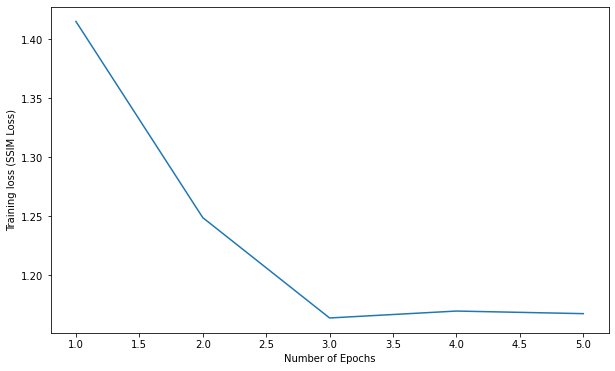

In [9]:
plt.figure(figsize=(10,6))
sns.lineplot(x=range(1, epochs+1), y=training_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Training loss (SSIM Loss)')
plt.show()

In [8]:
# Testing

# Declare experiment level variables
use_gpu = 1
ckpt_dir = './checkpoint'
save_dir = './data/test/be_enhanced/'
test_dir = './data/test/low'

# ckpt_dir = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/checkpoint'
# save_dir = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/enhanced_result'
# test_dir = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/data/test/low'

# Test the model
tf.reset_default_graph()
session = create_session(gpu_mode=use_gpu)
model = LLE(session)
LiCENt_test(model, ckpt_dir, test_dir, save_dir)

[*] GPU Mode

[*] Initialize model successfully...
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint\LiCENt-9400
[*] Load weights successfully...
[*] Testing...
No.[1/30]
No.[2/30]
No.[3/30]
No.[4/30]
No.[5/30]
No.[6/30]
No.[7/30]
No.[8/30]
No.[9/30]
No.[10/30]
No.[11/30]
No.[12/30]
No.[13/30]
No.[14/30]
No.[15/30]
No.[16/30]
No.[17/30]
No.[18/30]
No.[19/30]
No.[20/30]
No.[21/30]
No.[22/30]
No.[23/30]
No.[24/30]
No.[25/30]
No.[26/30]
No.[27/30]
No.[28/30]
No.[29/30]
No.[30/30]
[*] Average run time: 0.1771


#### Evaluate the model

In [9]:
test_low_data_name = glob(os.path.join('./data/test/low')+'/*.*')
test_high_data_name = glob(os.path.join('./data/test/high')+'/*.*')
enhanced_data_name = glob(os.path.join('./data/test/be_enhanced/')+'/*.*')

# test_low_data_name = glob(os.path.join('/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/data/test/low')+'/*.*')
# test_high_data_name = glob(os.path.join('/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/data/test/high')+'/*.*')
# enhanced_data_name = glob(os.path.join('/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/enhanced_result')+'/*.*')

In [10]:
assert len(test_low_data_name) == len(enhanced_data_name)
assert len(test_high_data_name) == len(enhanced_data_name)

In [11]:
# Calculate psnr

psnr_scores = []
for idx in range(len(enhanced_data_name)):
    low_im = cv.imread(test_high_data_name[idx])
    enh_im = cv.imread(enhanced_data_name[idx])
    psnr_scores.append(psnr_score(low_im, enh_im))


# mean psnr
psnr_val = np.round(np.mean(psnr_scores), 3)
print('psnr value --> {}'.format(psnr_val))

psnr value --> 27.985


In [12]:
# Calculate ssim

ssim_scores = []
for idx in range(len(enhanced_data_name)):
    high_im = cv.imread(test_high_data_name[idx])
    enh_im = cv.imread(enhanced_data_name[idx])
    ssim_scores.append(ssim_score(high_im, enh_im))


# mean psnr
ssim_val = np.round(np.mean(ssim_scores), 4)
print('ssim value --> {}'.format(ssim_val))

ssim value --> 0.6497


In [13]:
# calculate brisque

brisque_scores = []
for idx in range(len(enhanced_data_name)):
    brisque_scores.append(brisque_score(enhanced_data_name[idx]))

# mean brisque
brisque_val = np.round(np.mean(brisque_scores), 4)
print('brisque value --> {}'.format(brisque_val))

brisque value --> 33.0246


#### Enhanced Images - Training Data

In [14]:
# Testing

# Declare experiment level variables
use_gpu = 1
ckpt_dir1 = './checkpoint'
save_dir1 = './data/train/be_enhanced/'
train_dir1 = './data/train/low'

# ckpt_dir = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/checkpoint'
# save_dir = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/enhanced_result'
# test_dir = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/data/test/low'

# Test the model
tf.reset_default_graph()
session = create_session(gpu_mode=use_gpu)
model = LLE(session)
LiCENt_test(model, ckpt_dir1, train_dir1, save_dir1)

[*] GPU Mode

[*] Initialize model successfully...
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint\LiCENt-9400
[*] Load weights successfully...
[*] Testing...
No.[1/470]
No.[2/470]
No.[3/470]
No.[4/470]
No.[5/470]
No.[6/470]
No.[7/470]
No.[8/470]
No.[9/470]
No.[10/470]
No.[11/470]
No.[12/470]
No.[13/470]
No.[14/470]
No.[15/470]
No.[16/470]
No.[17/470]
No.[18/470]
No.[19/470]
No.[20/470]
No.[21/470]
No.[22/470]
No.[23/470]
No.[24/470]
No.[25/470]
No.[26/470]
No.[27/470]
No.[28/470]
No.[29/470]
No.[30/470]
No.[31/470]
No.[32/470]
No.[33/470]
No.[34/470]
No.[35/470]
No.[36/470]
No.[37/470]
No.[38/470]
No.[39/470]
No.[40/470]
No.[41/470]
No.[42/470]
No.[43/470]
No.[44/470]
No.[45/470]
No.[46/470]
No.[47/470]
No.[48/470]
No.[49/470]
No.[50/470]
No.[51/470]
No.[52/470]
No.[53/470]
No.[54/470]
No.[55/470]
No.[56/470]
No.[57/470]
No.[58/470]
No.[59/470]
No.[60/470]
No.[61/470]
No.[62/470]
No.[63/470]
No.[64/470]
No.[65/470]
No.[66/470]
No.[67/470]
No.[68/470]
N

In [15]:
all_low_data_name = glob(os.path.join('./data/train/low')+'/*.*')
all_high_data_name = glob(os.path.join('./data/train/high')+'/*.*')
all_enhanced_data_name = glob(os.path.join('./data/train/be_enhanced/')+'/*.*')

In [16]:
# Calculate psnr

psnr_scores = []
for idx in range(len(all_enhanced_data_name)):
    high_im = cv.imread(all_high_data_name[idx])
    enh_im = cv.imread(all_enhanced_data_name[idx])
    psnr_scores.append(psnr_score(high_im, enh_im))


# mean psnr
psnr_val = np.round(np.mean(psnr_scores), 3)
print('psnr value --> {}'.format(psnr_val))

psnr value --> 28.08


In [17]:
# Calculate ssim

ssim_scores = []
for idx in range(len(all_enhanced_data_name)):
    high_im = cv.imread(all_high_data_name[idx])
    enh_im = cv.imread(all_enhanced_data_name[idx])
    ssim_scores.append(ssim_score(high_im, enh_im))


# mean psnr
ssim_val = np.round(np.mean(ssim_scores), 4)
print('ssim value --> {}'.format(ssim_val))

ssim value --> 0.5901


In [18]:
# calculate brisque

brisque_scores = []
for idx in range(len(all_enhanced_data_name)):
    brisque_scores.append(brisque_score(all_enhanced_data_name[idx]))

# mean brisque
brisque_val = np.round(np.mean(brisque_scores), 4)
print('brisque value --> {}'.format(brisque_val))

brisque value --> 36.3431


### ExDark Dataset

In [7]:
use_gpu = 1
ckpt_dir0 = './checkpoint'
save_dir0 = './validation_data/ExDark/be_enhanced'
test_dir0 = './validation_data/ExDark/test'

# ckpt_dir = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/checkpoint'
# save_dir = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/enhanced_result'
# test_dir = '/gdrive/MyDrive/Colab Notebooks/Low Light Image Enhancement/LiCENt/data/test/low'

# Test the model
tf.reset_default_graph()
session = create_session(gpu_mode=use_gpu)
model = LLE(session)
LiCENt_test(model, ckpt_dir0, test_dir0, save_dir0)

[*] GPU Mode

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
[*] Initialize model successfully...
[*] Reading checkpoint...
INFO:tensorflow:Restoring parameters from ./checkpoint\LiCENt-9400
[*] Load weights successfully...
[*] Testing...
No.[1/100]
No.[2/100]
No.[3/100]
No.[4/100]
No.[5/100]
No.[6/100]
No.[7/100]
No.[8/100]
No.[9/100]
No.[10/100]
No.[11/100]
No.[12/100]
No.[13/100]
No.[14/100]
No.[15/100]
No.[16/100]
No.[17/100]
No.[18/100]
No.[19/100]
No.[20/100]
No.[21/100]
No.[22/100]
No.[23/100]
No.[24/100]
No.[25/100]
No.[26/100]
No.[27/100]
No.[28/100]
No.[29/100]
No.[30/100]
No.[31/100]
No.[32/100]
No.[33/100]
No.[34/100]
No.[35/100]
No.[36/100]
No.[37/100]
No.[38/100]
No.[39/100]
No.[40/100]
No.[41/100]
No.[42/100]
No.[43/100]
No.[44/100]
No.[45/100]
No.[46/100]
No.[47/100]
No.[48/100]
No.[49/100]
No.[50/100]
No.[51/100]
No.[52/100]
No.[53/100]
No.[54/100]
No.[55/100]
No.[56/100]
No.[57/10

In [8]:
val_low_data_name = glob(os.path.join('./validation_data/ExDark/test/')+'/*.*')
val_enhanced_data_name = glob(os.path.join('./validation_data/ExDark/be_enhanced/')+'/*.*')

In [9]:
# calculate brisque

brisque_scores = []
for idx in range(len(val_enhanced_data_name)):
    brisque_scores.append(brisque_score(val_enhanced_data_name[idx]))

# mean brisque
brisque_val = np.round(np.mean(brisque_scores), 4)
print('brisque value --> {}'.format(brisque_val))

brisque value --> 29.0156
